In [184]:
# Run this cell only once
!git clone https://github.com/projeto-de-algoritmos/Final_DroneDeliveryScheduler

Cloning into 'Final_DroneDeliveryScheduler'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 98 (delta 41), reused 76 (delta 24), pack-reused 0
Unpacking objects: 100% (98/98), done.


In [185]:
%cd Final_DroneDeliveryScheduler

/content/Final_DroneDeliveryScheduler/Final_DroneDeliveryScheduler/Final_DroneDeliveryScheduler/Final_DroneDeliveryScheduler/Final_DroneDeliveryScheduler/Final_DroneDeliveryScheduler/Final_DroneDeliveryScheduler/Final_DroneDeliveryScheduler


In [186]:
import delivery
from delivery.graph_utils import find_shortest_path
from mock_data.data import RandomAerialImageDataGenerator
from delivery.visualization_utils import *

from IPython.display import clear_output, display
import ipywidgets
import operator
from IPython.display import Markdown as md

In [187]:
# initialize the random data generator
random_data_generator = RandomAerialImageDataGenerator(
    width=24*14,
    height=24*14,
    col_size=24,
    row_size=24,
)

In [188]:
slider_maximum_flight_time = ipywidgets.IntSlider(
    value=40, min=10, max=80, step=1
)
slider_num_mav = ipywidgets.IntSlider(
    value=3, min=1, max=5, step=1
)
slider_num_packets = ipywidgets.IntSlider(
    value=2, min=1, max=10, step=1
)

In [189]:
# widgets
update_data_button = ipywidgets.Button(description='UPD DATA')
update_routes_button = ipywidgets.Button(description='UPD ROUTES')

output_map = ipywidgets.Output()
output_map_with_routes = ipywidgets.Output()
output_deliveries = ipywidgets.Output()
output_scheduled_deliveries = ipywidgets.Output()

In [190]:
def update_random_data(unuseful_arg):
    global data
    # Generate random data.
    data = random_data_generator.generate(
        slider_num_packets.value
    )
    # Plot the generated map (frame grid).
    with output_map:
        clear_output(True)
        plot_frame(
            data.map,
            width=data.map.shape[0],
            height=data.map.shape[1]
        )

In [191]:
COLOR_OPTIONS = [
    # [255,0  ,0  ],  # blue
    [255,255,0  ],  # turquoise
    [255,0  ,255],  # purple
    # [0,  0,  0  ],  # black
    # [0  ,255,0  ],  # green
    # [0  ,0  ,255],  # red
    [255,255,255],  # white
    # [0  ,255,255],  # yellow  
]
tmp_color_options = COLOR_OPTIONS[:]


def update_routes(unuseful_arg):
    # data, params
    global tmp_color_options
    path_list, distance_list = find_shortest_path(
        data.helipad_coord.copy(),
        data.goal_coord_list.copy(),
        data.adj_matrix.copy(),
        data.weight_map.copy()
    )

    frame_to_plot = data.map.copy()

    with output_map_with_routes:
        clear_output(True)
        if len(path_list) > 1:
            for path in path_list:
                if len(tmp_color_options) < 1:
                    tmp_color_options = COLOR_OPTIONS[:]
                color_idx = np.random.choice(len(tmp_color_options))
                color = tmp_color_options[color_idx][:]
                del tmp_color_options[color_idx]
                prev_coord = path[0][:]
                for coord in path[1:]:
                    frame_to_plot = cv2.line(
                        frame_to_plot,
                        (12+prev_coord[1]*random_data_generator.row_size,
                         12+prev_coord[0]*random_data_generator.col_size),
                        (12+coord[1]*random_data_generator.row_size,
                         12+coord[0]*random_data_generator.col_size),
                         color,
                         5
                    )
                    prev_coord = coord[:]
            plot_frame(
                frame_to_plot,
                width=frame_to_plot.shape[0],
                height=frame_to_plot.shape[1]
            )
        else:
            plot_frame(
                frame_to_plot,
                width=frame_to_plot.shape[0],
                height=frame_to_plot.shape[1]
            )
            print('No path found!')
    update_delivery_data(unuseful_arg=None)

In [192]:
def random_normalized_data(shape, min_value, max_value):
    return np.random.random(shape) * (max_value-min_value) + min_value

In [193]:
def interval_scheduling(uav_quantity, flight_time, goal_flight_time_list, goal_revenue_list):
    total_flight_time_available = uav_quantity * flight_time
    total_delivery_flight_time = sum(goal_flight_time_list)

    if total_delivery_flight_time < total_flight_time_available:
      all = []
      for i in range(0, len(goal_revenue_list)):
        all.append({'Delivery Number': list_with_revenue_and_delivery_number[i]['Delivery Number'],
                    'Revenue': goal_revenue_list[i]})
        
      return all

    revenue_per_time = []
    for i in range(0, len(goal_revenue_list)):
        proportion = float(goal_revenue_list[i]/goal_flight_time_list[i])
        dictio = {'proportion': proportion,
                  'index_at_goal_flight_time_list': i,
                  'Delivery Number': list_with_revenue_and_delivery_number[i]}
        revenue_per_time.append(dictio)

    revenue_per_time.sort(key=operator.itemgetter('proportion'))

    deliveries = []
    aux = 0
    for i in range(len(revenue_per_time)-1, 0, -1):
        if (aux + goal_flight_time_list[revenue_per_time[i]['index_at_goal_flight_time_list']] > total_flight_time_available):
            next
        else:
            aux += goal_flight_time_list[revenue_per_time[i]
                                         ['index_at_goal_flight_time_list']]
            deliveries.append(revenue_per_time[i]['Delivery Number'])

    return deliveries

In [194]:
def update_delivery_data(unuseful_arg):
    global list_with_revenue_and_delivery_number
    goal_flight_time_list = random_normalized_data(slider_num_packets.value, 50, 200).round().astype(np.int16)
    flight_time = random_normalized_data(1, 50, 200).round().astype(np.int16)
    goal_revenue_list = random_normalized_data(slider_num_packets.value, 1, 100).round().astype(np.int16)
    
    random_delivery_numbers = random_normalized_data(slider_num_packets.value, 10000, 55000).round().astype(np.int32)
    
    list_with_revenue_and_delivery_number = []
    for i in range(0, len(goal_revenue_list)):
        dictio = {'Delivery Number': random_delivery_numbers[i], 'Revenue': goal_revenue_list[i]}
        list_with_revenue_and_delivery_number.append(dictio)
        
    # TODO: printar q nem embaixo
    with output_deliveries:
        clear_output(True)
        output_deliveries_string = "Random Delivery data \n"
        for random in list_with_revenue_and_delivery_number:
          output_deliveries_string += f"Delivery Number: {random['Delivery Number']}  Revenue: {random['Revenue']} \n"
        
        
        print(output_deliveries_string)


    scheduled_deliveries = interval_scheduling(
        slider_num_mav.value, flight_time,
        goal_flight_time_list, goal_revenue_list
    )
    result_string = ""

    for delivery in scheduled_deliveries:
        result_string += f"Delivery Number: {delivery['Delivery Number']}  Revenue: {delivery['Revenue']} \n"

    with output_scheduled_deliveries:
        clear_output(True)
        print(f"#Scheduled Deliveries: \n{result_string}")

In [195]:
# slider_maximum_flight_time.observe(update_params, names='value')
# slider_num_mav.observe(update_params, names='value')
# slider_num_packets.observe(update_params, names='value')

update_data_button.on_click(update_random_data)
update_routes_button.on_click(update_routes)

In [196]:
# initialize the app
# update_params(unuseful_arg=None)
update_random_data(unuseful_arg=None)
update_routes(unuseful_arg=None)

## **How to use**

There's a button to generate new random data and another one to update the routes. If you generate new data, please wait for the images to show up before pressing the "update routes" button.


"assets/drone_traffic.jpg"

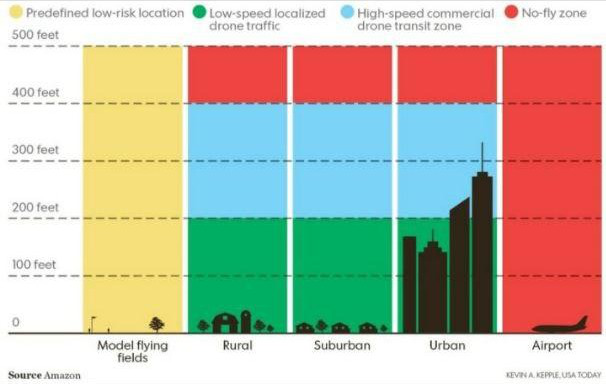

In [197]:
from PIL import Image

Image.open("assets/drone_traffic.jpg")

### **Maximum Flight Time** (minutes)
Maximum flight time of each MAV. We assume that there's only one type of MAV and that every battery lasts the same amount of time.


In [198]:
display(slider_maximum_flight_time)

IntSlider(value=40, max=80, min=10)

### **Number of MAVs**

In [199]:
display(slider_num_mav)

IntSlider(value=3, max=5, min=1)

### **Number of Packets**

In [200]:
display(slider_num_packets)

IntSlider(value=2, max=10, min=1)

### **Update the random image.**


In [201]:
display(update_data_button)

Button(description='UPD DATA', style=ButtonStyle())

### **Update the routes.**


In [202]:
display(update_routes_button)

Button(description='UPD ROUTES', style=ButtonStyle())

### **Random Image**

In [203]:
display(output_map)

Output()

### **Random Image With the Routes of the MAVs**

In [204]:
display(output_map_with_routes)

Output()

### Deliveries

In [205]:
display(output_deliveries)

Output()

### Scheduled Deliveries

In [206]:
display(output_scheduled_deliveries)

Output()